In [ ]:
print("Furkan'ın kitabı")


* ResNet'in ortaya çıkmasının nedeni Vanishing Gradient Problemdır.
* Hidden Layer sayısı arttıkça high level layerı etkilyen low level bilgisi kayboluyor.
* Gradient lossun weightlere göre türevidir.

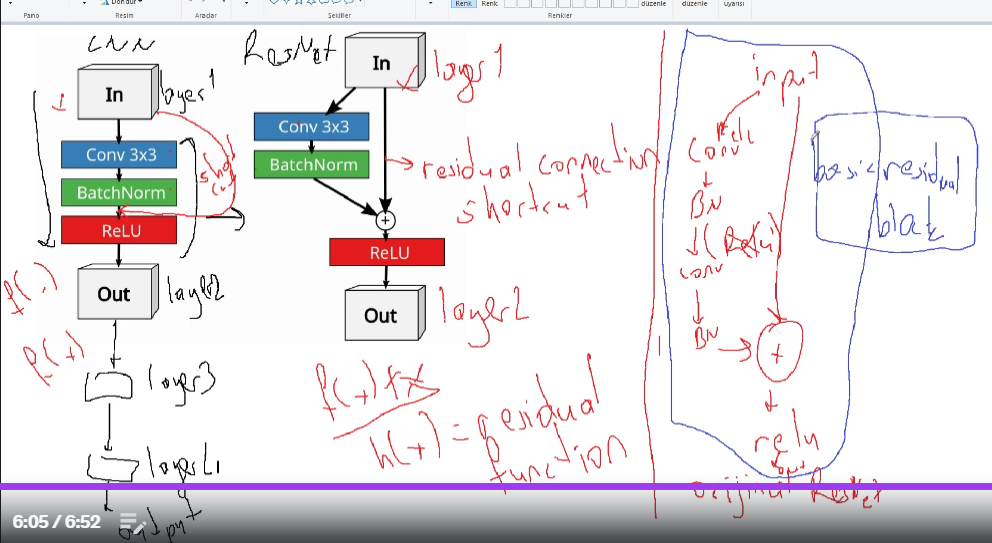

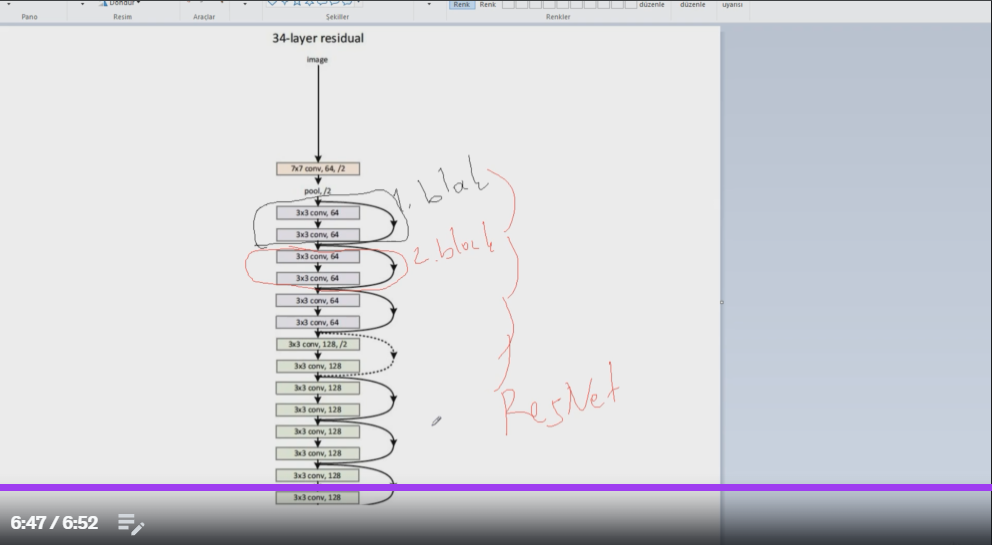

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import time

In [2]:
# device confic EKSTRA DEFAULT CPU but GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

Device:  cpu


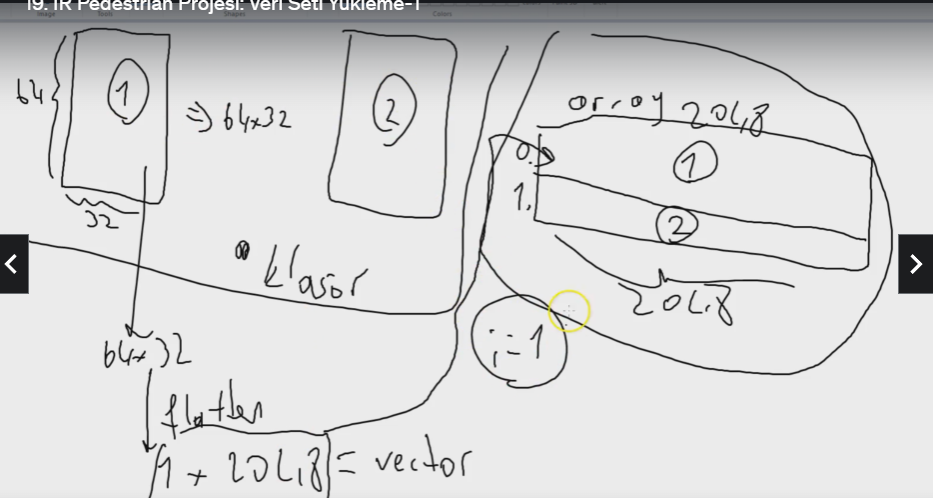

In [3]:
def read_images(path, num_img):
    array = np.zeros([num_img, 64*32])
    i = 0
    for img in os.listdir(path):
        img_path = path + "\\" + img
        img = Image.open(img_path, mode = "r")
        data = np.asarray(img, dtype = "uint8")
        data = data.flatten()
        array[i,:] = data
        i += 1
    return array

In [4]:
# read train negative
train_negative_path = r"LSIFIR\Classification\Train\neg"
num_train_negative_img = 43390
train_negative_array = read_images(train_negative_path, num_train_negative_img) 

In [5]:
# numpy arrayı toruch tensorune çevirdik
x_train_negative_tensor = torch.from_numpy(train_negative_array)
print("x_train_negative_tensor:", x_train_negative_tensor.size())

x_train_negative_tensor: torch.Size([43390, 2048])


In [6]:
y_train_negative_tensor = torch.zeros(num_train_negative_img, dtype = torch.long)
print("y_train_negatice_tensor:", y_train_negative_tensor.size())

y_train_negatice_tensor: torch.Size([43390])


In [7]:
# read train positive
train_positive_path = r"LSIFIR\Classification\Train\pos"
num_train_positive_img = 10208
train_positive_array = read_images(train_positive_path, num_train_positive_img) 

x_train_positive_tensor = torch.from_numpy(train_positive_array)
print("x_train_positive_tensor:", x_train_positive_tensor.size())

y_train_positive_tensor = torch.ones(num_train_positive_img, dtype = torch.long)
print("y_train_positive_tensor:", y_train_positive_tensor.size())

x_train_positive_tensor: torch.Size([10208, 2048])
y_train_positive_tensor: torch.Size([10208])


In [8]:
# concat train
x_train = torch.cat((x_train_negative_tensor,x_train_positive_tensor),0) # satırları birleştirmek için 0
y_train = torch.cat((y_train_negative_tensor,y_train_positive_tensor),0)
print("x_train: ",x_train.size())
print("y_train: ",y_train.size())

x_train:  torch.Size([53598, 2048])
y_train:  torch.Size([53598])


In [9]:
# --------------------------------------------------------
# read test negative  22050
test_negative_path = r"LSIFIR\Classification\Test\neg"
num_test_negative_img = 22050
test_negative_array = read_images(test_negative_path,num_test_negative_img)
x_test_negative_tensor = torch.from_numpy(test_negative_array[:20855,:])
print("x_test_negative_tensor: ",x_test_negative_tensor.size())
y_test_negative_tensor = torch.zeros(20855,dtype = torch.long)
print("y_test_negative_tensor: ",y_test_negative_tensor.size())

# read test positive 5944
test_positive_path = r"LSIFIR\Classification\Test\pos"
num_test_positive_img = 5944
test_positive_array = read_images(test_positive_path,num_test_positive_img)
x_test_positive_tensor = torch.from_numpy(test_positive_array)
print("x_test_positive_tensor: ",x_test_positive_tensor.size())
y_test_positive_tensor = torch.zeros(num_test_positive_img,dtype = torch.long)
print("y_test_positive_tensor: ",y_test_positive_tensor.size())

# concat test
x_test = torch.cat((x_test_negative_tensor, x_test_positive_tensor), 0)
y_test = torch.cat((y_test_negative_tensor, y_test_positive_tensor), 0)
print("x_test: ",x_test.size())
print("y_test: ",y_test.size())

x_test_negative_tensor:  torch.Size([20855, 2048])
y_test_negative_tensor:  torch.Size([20855])
x_test_positive_tensor:  torch.Size([5944, 2048])
y_test_positive_tensor:  torch.Size([5944])
x_test:  torch.Size([26799, 2048])
y_test:  torch.Size([26799])


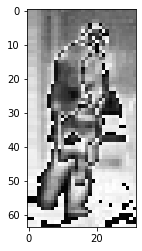

In [10]:
# visualize
plt.imshow(x_train[45001,:].reshape(64,32), cmap = "gray")

In [13]:
# Hyperparameter
num_epochs = 5000
num_classes = 2
batch_size = 8933
learning_rate = 0.00001

In [14]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net,self).__init__()
        
        self.conv1 = nn.Conv2d(1,10,5) # input channel, output channel, filter size (5*5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(10,16,5)
        
        self.fc1 = nn.Linear(16*13*5,520) # input, output
        self.fc2 = nn.Linear(520,130)
        self.fc3 = nn.Linear(130,num_classes)

    def forward(self, x):
        
        x = self.pool(F.relu((self.conv1(x))))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1,16*13*5) # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Bizim örneğimizde image shape 64x32. Padding değeri girmiyoruz, varsayılan değerini alıyor ki o da 0'a eşit. Stride değeri girmiyoruz, varsayılan değeri 1. Dilation değeri girmiyoruz, varsayılan değeri 1. Bu bilgileri toparladığımızda;

o = output = bilinmeyenimiz

p = padding = 0

k = kernel_size = 5

s = stride = 1

d = dilation = 1

i =input shape = 64x32

Bir Conv2d metoduna giren bir input aşağıdaki formüle göre çıkış boyutu verir.

o = [i + 2p - k - (k-1)(d-1)]/s + 1 Kendi parametre değerlerimizle çözüm yaptığımızda;

i=64 için o=60,

i=32 için o=28 çıkar. Böylece inputumuz ilk Conv2d metodundan çıktığında 60x28 shape'ini alıyor.

Ardından MaxPooling2d yapıyoruz. Örneğimizde pool_size=(2,2) belirlediğimiz için 60x28 shape'i 30x14'e indiriyoruz.

Ardından 30x14 için tekrar Conv2d uyguluyoruz.

i=30 için o=26,

i=14 için o=10, böylece inputumuz ikinci Conv2d metodundan çıktığında 26x10 shape'ini alıyor.

Ardından tekrar MaxPooling2d yapıyoruz. Örneğimizde pool_size=(2,2) belirlediğimiz için 26x10 shape'i 13x5'e indiriyoruz.

Son Conv2d metodunda feature map sayısını 16 olarak belirlediğimiz için elimizde 16 adet 13x5 image oluyor. Bu yüzden nn.Linear(16135,520) yazıyoruz. Umarım faydalı olur.

In [15]:
import torch.utils.data

train = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True )

test = torch.utils.data.TensorDataset(x_test, y_test)
testloader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False )

In [16]:
net = Net()
# net = Net().to(device)

In [17]:
#%% loss and optimizer
criterion = nn.CrossEntropyLoss()

In [18]:
import torch.optim as optim
optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum=0.8) # momentum SGD'nin hızlanma parametresi

In [19]:
#%% train a network
start = time.time() # başlangıç zamanını tutar
train_acc = []
test_acc = []
loss_list = []
use_gpu = False # True

In [ ]:
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0): # saymaya sıfırdan başla
        
        inputs, labels = data
        inputs = inputs.view(batch_size, 1, 64, 32) # reshape
        inputs = inputs.float() # float
        
        # use gpu
        if use_gpu:
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)
                
        # zero gradient
        optimizer.zero_grad()
        
        # forward
        outputs = net(inputs)
        
        # loss
        loss = criterion(outputs, labels)
        
        # back
        loss.backward()
        
        # update weights
        optimizer.step()
    
    # test
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels= data
            
            images = images.view(batch_size,1,64,32)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
            
            outputs = net(images)
            
            _, predicted = torch.max(outputs.data,1) # dimension. Yani bu  aramayı satılarda mı yoksa sutunlarda mı yapacak anlamına geliyor. 1 demek satırlarda ara demek.
            
            total += labels.size(0) 
            correct += (predicted == labels).sum().item() # sayıya çevirmek içim .item()
        
    acc1 = 100*correct/total
    print("accuracy test: ",acc1)
    test_acc.append(acc1)

    # train
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels= data
            
            images = images.view(batch_size,1,64,32)
            images = images.float()
            
            # gpu
            if use_gpu:
                if torch.cuda.is_available():
                    images, labels = images.to(device), labels.to(device)
            
            outputs = net(images)
            
            _, predicted = torch.max(outputs.data,1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
    acc2 = 100*correct/total
    print("accuracy train: ",acc2)
    train_acc.append(acc2)


print("train is done.")

accuracy test:  78.65965147953281
accuracy train:  70.76756595395351
accuracy test:  99.3134072166872
accuracy train:  80.05709168252547
accuracy test:  97.57080488077914
accuracy train:  79.2398970110825
accuracy test:  86.49203328482406
accuracy train:  75.82185902459047
accuracy test:  83.86506959214896
accuracy train:  75.49908578678308
accuracy test:  89.31303406843539
accuracy train:  77.74543826262175
accuracy test:  90.41008992872868
accuracy train:  78.49360050748162
accuracy test:  89.53319153699765
accuracy train:  78.7286839061159
accuracy test:  89.38393223627747
accuracy train:  79.0645173327363
accuracy test:  89.72349714541588
accuracy train:  79.53468413000485
accuracy test:  89.92872868390612
accuracy train:  79.92462405313631
accuracy test:  90.08918243218031
accuracy train:  80.28284637486473
accuracy test:  90.27202507556252
accuracy train:  80.60002238889511
accuracy test:  90.19366394268442
accuracy train:  80.89480950781746
accuracy test:  90.37277510354863
accu

accuracy train:  89.5742378446957
accuracy test:  90.43621030635471
accuracy train:  89.59102951602672
accuracy test:  90.31680286577857
accuracy train:  89.63953878876077
accuracy test:  90.38770103362066
accuracy train:  89.65073323631479
accuracy test:  90.45113623642673
accuracy train:  89.6637934251278
accuracy test:  90.36531213851264
accuracy train:  89.70483973282585
accuracy test:  90.2608306280085
accuracy train:  89.77014067689093
accuracy test:  90.31680286577857
accuracy train:  89.77946938318594
accuracy test:  90.28695100563453
accuracy train:  89.81678420836599
accuracy test:  90.30560841822457
accuracy train:  89.83917310347401
accuracy test:  90.1675435650584
accuracy train:  89.86342773984104
accuracy test:  90.3429232434046
accuracy train:  89.88395089369007
accuracy test:  90.19739542520243
accuracy train:  89.92686294264712
accuracy test:  90.12649725736036
accuracy train:  89.94365461397814
accuracy test:  90.35784917347662
accuracy train:  89.95298332027315
accu

In [ ]:
end = time.time()
process_time = (end - start)/60
print("process time: ",process_time)